# **Décodage d'un code convolutif à l'aide de RNN**

## **Boite à idée**

## **1. Importation des modules**

In [18]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from CC import *
from convolutif import *
from Variante import va
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras import optimizers
from datetime import datetime
import tensorflow as tf

## **2. Création du dataset**

#### **Données bruitées à SNR fixe**

In [2]:
## Choix des paramètres 
n = 50000  # taille jeu de données
trame = 100  # taille trame
SNR = 2  # Choix du SNR
N0 = 10**(-SNR/10)
Ec = 1/2

learning_rate = 0.001394108


## Création de X les targets et Y les labels 
Y = rd.randint (0, 2, (n, trame, 1))
N0 = 10**(-SNR/10)
bruit = np.sqrt (N0/2) * np.random.randn(len(Y), trame, 2)
X = (-2 * np.array([cc2(h) for h in Y]) + 1) * np.sqrt(Ec) + bruit


## Répartition données train et données test
xtrain, xtest, ytrain, ytest = train_test_split (X, Y, test_size = 0.20)

## **3. Visualisation du dataset**

In [20]:
print (f" xtrain.shape : {xtrain.shape}")
print (f" ytrain.shape : {ytrain.shape}")
print (f" xtest.shape : {xtest.shape}")
print (f" ytest.shape : {ytest.shape}")
print (" ")
print (" Les entrées sont des message du type :")
print (xtrain[0][:4])
print (" ")
print (" ")
print (" les sorties sont des messages du type :")
print (ytrain[0][:4])

 xtrain.shape : (40000, 100, 2)
 ytrain.shape : (40000, 100, 1)
 xtest.shape : (10000, 100, 2)
 ytest.shape : (10000, 100, 1)
 
 Les entrées sont des message du type :
[[ 0.35612723 -2.02939635]
 [ 0.89926102 -1.46594381]
 [ 0.74131773 -0.04141117]
 [-0.55883183 -0.35507654]]
 
 
 les sorties sont des messages du type :
[[0]
 [0]
 [0]
 [1]]


## **4. Création du modèle**

In [21]:
model = Sequential ()

model.add (layers.Input (shape = (trame, 2)))


model.add (layers.Dropout (0.2))
model.add (layers.Bidirectional (layers.SimpleRNN (64, return_sequences = True)))
model.add (layers.BatchNormalization ())
model.add (layers.Dropout (0.2))
model.add (layers.Bidirectional (layers.SimpleRNN (64, return_sequences = True)))
model.add (layers.BatchNormalization ())
model.add (layers.Dense (128, activation = "sigmoid"))
model.add (layers.Dense (128, activation = "sigmoid"))

model.add (layers.Dense (1, activation = "sigmoid"))

model.summary ()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 100, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 128)       │         8,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 100, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100, 128)       │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100, 128)       │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100, 1)         │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,457 (263.50 KB)

 Trainable params: 66,945 (261.50 KB)

 Non-trainable params: 512 (2.00 KB)

## **5. Entrainnement du modèle**

In [22]:
sigma_0 = 0.05
P = 30

class SimulatedAnnealingCallback(tf.keras.callbacks.Callback):
    def __init__(self, sigma_0, P):
        super(SimulatedAnnealingCallback, self).__init__()
        self.sigma_0 = sigma_0
        self.P = P
        self.current_epoch = 0
 
    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch = epoch
        sigma_p = self.sigma_0 * (1 - epoch / self.P)
 
        for var in self.model.trainable_variables:
            noise = tf.random.normal(shape=var.shape, stddev=sigma_p)
            var.assign_add(noise)
 
        print(f"   Epoch {epoch+1}/{self.P} - Applied SA noise (σ={sigma_p:.4f})")

sa_callback = SimulatedAnnealingCallback(sigma_0, P)

In [23]:
accurate = 0.981

class StopWhenAccuracyReached(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target_accuracy:
            print(f"\n Accuracy {val_acc:.4f} atteinte à l'époque {epoch + 1}, arrêt de l'entraînement.")
            self.model.stop_training = True  


Target = StopWhenAccuracyReached(accurate)

In [24]:
EarlyStopping = callbacks.EarlyStopping (monitor = "val_accuracy", patience = 1)
TensorBoard = callbacks.TensorBoard (log_dir = "rnnCC1", histogram_freq = 1)
CheckPoint = callbacks.ModelCheckpoint (filepath = "rnnCC1.keras", monitor = "val_accuracy", save_best_only = True)
ReduceLR = callbacks.ReduceLROnPlateau (monitor = "val_loss", factor = 0.1, patience = 10)


optimizerA = optimizers.Adam (learning_rate = 0.001394108, clipnorm = 1.)
optimizerB = optimizers.RMSprop (learning_rate = 0.001394108, clipnorm = 1.)

In [25]:
model.compile (optimizer = optimizerA, loss = "bce", metrics = ["accuracy"])

history = model.fit (xtrain, 
                     ytrain,
                     epochs = 20, 
                     verbose = 1, 
                     validation_data = (xtest, ytest), 
                     callbacks = [CheckPoint], 
                     batch_size = 16)

Epoch 1/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 109s 43ms/step - accuracy: 0.8243 - loss: 0.3418 - val_accuracy: 0.9607 - val_loss: 0.1059
Epoch 2/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 108s 43ms/step - accuracy: 0.9056 - loss: 0.2170 - val_accuracy: 0.9743 - val_loss: 0.0720
Epoch 3/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 108s 43ms/step - accuracy: 0.9136 - loss: 0.2013 - val_accuracy: 0.9764 - val_loss: 0.0659
Epoch 4/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 109s 44ms/step - accuracy: 0.9160 - loss: 0.1960 - val_accuracy: 0.9768 - val_loss: 0.0662
Epoch 5/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 109s 44ms/step - accuracy: 0.9172 - loss: 0.1936 - val_accuracy: 0.9770 - val_loss: 0.0645
Epoch 6/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 107s 43ms/step - accuracy: 0.9177 - loss: 0.1927 - val_accuracy: 0.9779 - val_loss: 0.0602
Epoch 7/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 107s 43ms/step - accuracy: 0.9193 - loss: 0.1896 - val_accuracy: 0.9780 - val_loss: 0.0644
Epoch 8/12
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 106s 43ms/step - accuracy: 

## **6. Visualisation des performances**

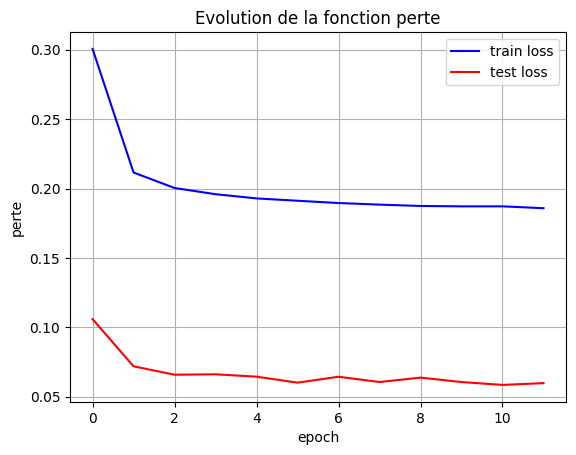

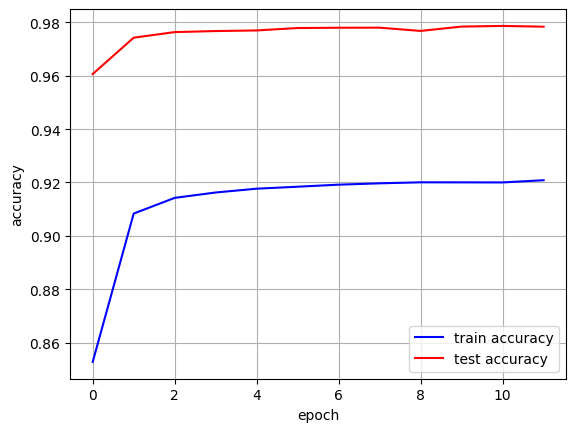

In [26]:
trainloss = history.history ["loss"]
testloss = history.history ["val_loss"]
trainaccuracy = history.history ["accuracy"]
testaccuracy = history.history ["val_accuracy"]

plt.plot (range (20), trainloss, "b", label = "train loss")
plt.plot (range (20), testloss, "r", label = "test loss")
plt.title ("Evolution de la fonction perte")
plt.xlabel ("epoch")
plt.ylabel ("perte")
plt.legend ()
plt.grid (True)
plt.show ()


plt.plot (range (20), trainaccuracy, "b", label = "train accuracy")
plt.plot (range (20), testaccuracy, "r", label = "test accuracy")
#plt.title ("Evolution de la fonction accuracy")
plt.xlabel ("epoch")
plt.ylabel ("accuracy")
plt.legend ()
plt.grid (True)
#plt.savefig(f"Courbes/RNN/21a{datetime.now().strftime('%H%M')}.png", dpi=300)
plt.show ()

## **8. Validation du modèle**

In [11]:
n_eval = 200000
trame_eval = 100

yeval = rd.randint (0, 2, (n_eval, trame_eval, 1))
N0 = 10**(-SNR/10)
bruit = np.sqrt (N0/2) * np.random.randn(len(yeval), trame_eval, 2)
xeval = (-2 * np.array([cc2(h) for h in yeval]) + 1) * np.sqrt(Ec) + bruit

In [27]:
loss, accuracy = model.evaluate (xeval, yeval)
print (" ")
print (f" Le modèle a une précision de {accuracy*100} pourcent pour un SNR de {SNR}")

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 100s 16ms/step - accuracy: 0.9779 - loss: 0.0606
 
 Le modèle a une précision de 97.80429601669312 pourcent pour un SNR de 2


## **9. Sauvegarde du modèle**

In [28]:
model.save("rnnCCRNN.keras")